# Extend bathymetry demo
* Given a topobathy cross-section, from ADCP gaged station, extend topobathy to above water topo.
* use NHGF nldi_xstool package (soon to be web service)

In [1]:
%matplotlib inline
from nldi_xstool.nldi_xstool import getXSAtEndPts
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import py3dep
import xarray as xr
from pathlib import Path
from shapely.geometry import Point, LineString

### Read bathy as .csv file

In [2]:
bfile = Path('../data/09152500_2019-10-25_bathymetry.csv')
print(bfile.exists())
data = pd.read_csv(bfile)
# data


True


<ipython-input-3-5688062980b7>:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_data2.to_file('../data/bathy.shp')


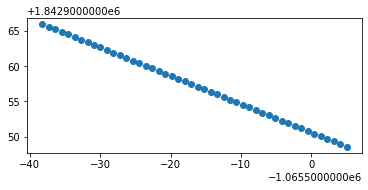

In [3]:
# Create GeoDataFrame and convert to albers conic to properly calculate geometry

gdf_data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Lon_NAD83, data.Lat_NAD83))
gdf_data2 = gdf_data.set_crs('epsg:4326')

# rename the elevation data - will make concatenating new topography easier later
gdf_data2["elevation"] = data["Bed_Elevation_meters_NAVD88"]

gdf_data2 = gdf_data2.to_crs('epsg:5071')
gdf_data2.plot()
gdf_data2.to_file('../data/bathy.shp')

In [4]:
# Clean up new GeoDataFrame - again will make concatenating easier later

del gdf_data2['Lat_NAD83']
del gdf_data2['Lon_NAD83']
del gdf_data2['Bed_Elevation_meters_NAVD88']
# gdf_data2

### Calculate some geometry to determine new end-points of cross-section

In [5]:
npts = len(gdf_data2)
p1 = np.array(gdf_data2.geometry[0])
p2 = np.array(gdf_data2.geometry[npts-1])
dx = p2[0] - p1[0]
dy = p2[1] - p1[1]
theta = np.arctan2(dy,dx)
length = np.sqrt(np.sum(np.square(p2-p1)))
print(p1, p2, dx, dy, theta, length)

[-1065538.2231083   1842965.99183045] [-1065495.00447954  1842948.56540859] 43.218628763454035 -17.426421852549538 -0.38327529948847305 46.59967865528981


In [6]:
# Calculate the new cross-section end points based on an extension length
extension = 200
p2ny = p1[1] + (length+extension)*np.sin(theta)
p2nx = p1[0] + (length+extension)*np.cos(theta)
p1ny = p1[1] - (extension)*np.sin(theta)
p1nx = p1[0] - (extension)*np.cos(theta)
print(p1nx, p1ny, p2nx, p2ny)

-1065723.7120644941 1843040.7838562937 -1065309.5155233452 1842873.7733827445


### Create new GeoDataFrames based on new cross-section endpoints
* then reproject to geographic ('epsg:4326') to use getXSAtEndPts service

In [7]:
df_pre = pd.DataFrame([{'lon': p1nx, 'lat': p1ny},
                    {'lon': p1[0], 'lat': p1[1]}])

df_post = pd.DataFrame([{'lon': p2[0], 'lat': p2[1]},
                    {'lon': p2nx, 'lat': p2ny}])

gdf_pre = gpd.GeoDataFrame(df_pre, geometry=gpd.points_from_xy(df_pre.lon, df_pre.lat)).set_crs('epsg:5071')
gdf_pre_geo = gdf_pre.to_crs('epsg:4326')

gdf_post = gpd.GeoDataFrame(df_pre, geometry=gpd.points_from_xy(df_post.lon, df_post.lat)).set_crs('epsg:5071')
gdf_post_geo = gdf_post.to_crs('epsg:4326')

In [8]:
def getxs(gdf, numpts, res):
    return getXSAtEndPts([(gdf.geometry[0].x, gdf.geometry[0].y),(gdf.geometry[1].x, gdf.geometry[1].y)], 
                         numpts=numpts, crs='epsg:4326', res=res)

### Re-project to 

In [9]:
new_df_pre = getxs(gdf_pre_geo, 201, 1).to_crs('epsg:5071')
new_df_post = getxs(gdf_post_geo, 201, 1).to_crs('epsg:5071')

In [49]:
new_df_pre['code'] = "0"
new_df_post['code'] = "0"
gdf_data2['code'] = '1'

In [50]:
print(type(new_df_pre), new_df_pre.crs)

<class 'geopandas.geodataframe.GeoDataFrame'> epsg:5071


<AxesSubplot:xlabel='z'>

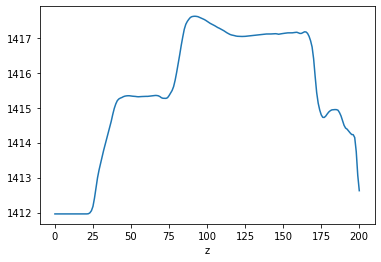

In [51]:
new_df_pre.elevation.plot()

In [52]:
xs_complete = gpd.GeoDataFrame( pd.concat( [new_df_pre, gdf_data2, new_df_post], ignore_index=True), crs='epsg:5071' )

<AxesSubplot:>

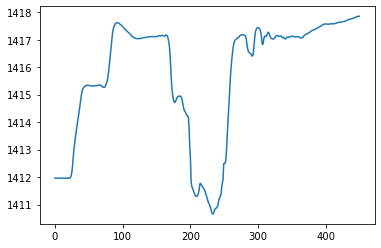

In [53]:
xs_complete.elevation.plot()

In [54]:
xs_complete['station'] = 0.0

def distance(p1t, p2t):
    return np.sqrt(np.sum(np.square(np.array(p2t)-np.array(p1t))))

for index, v in xs_complete.iterrows():
    if index == 0:
        p1 = v.geometry
    xs_complete.at[index, 'station'] = distance(p1, v.geometry)
    
    

In [55]:
xs_complete.code

0      0
1      0
2      0
3      0
4      0
      ..
445    0
446    0
447    0
448    0
449    0
Name: code, Length: 450, dtype: object

### Calculate bounding box of complete line, buffer, then use to pull 3dep topo

In [39]:
xstmp = xs_complete.to_crs('epsg:3857')
p1x = xstmp.geometry[0].x
p1y = xstmp.geometry[0].y
print(p1x, p1y)
p2x = xstmp.geometry[-1:].x
p2y = xstmp.geometry[-1:].y
xsline = LineString([(p1x, p1y), (p2x, p2y)])
# xsline = LineString([(p1nx, p1ny), (p2nx, p2ny)])
xslineb = xsline.buffer(200)
bbox = xslineb.bounds

dem = py3dep.get_map("DEM", bbox, resolution=1, geo_crs="epsg:3857", crs="epsg:3857")

-12073003.532524342 4719374.465782366


In [57]:
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l=='0':
            cols.append('red')
        else:
            cols.append('blue')
    return cols

cols = pltcolor(xs_complete.code.values)

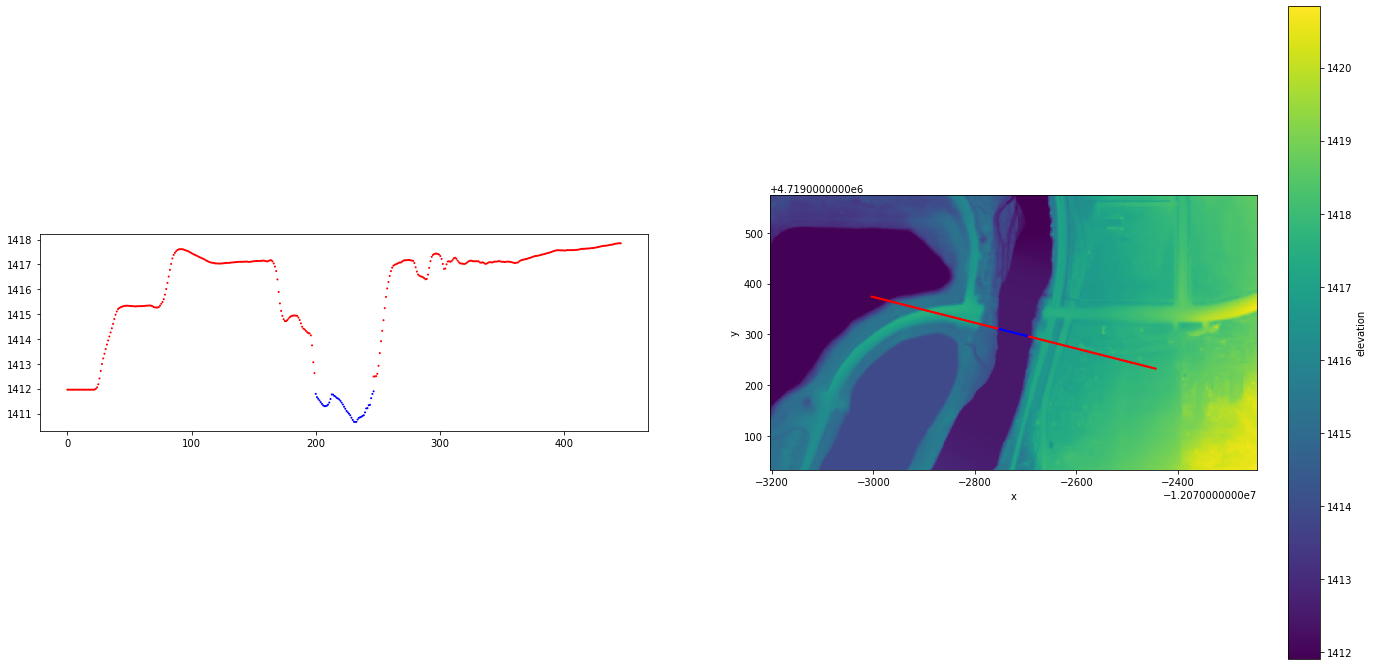

In [64]:
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].scatter(xs_complete.station.values, xs_complete.elevation.values, s=1, c=cols)
ax[0].set_aspect('20')

dem.plot(ax=ax[1])
ax[1].scatter(xstmp.geometry.x, xstmp.geometry.y, s=1, c=cols)
ax[1].set_aspect('equal')

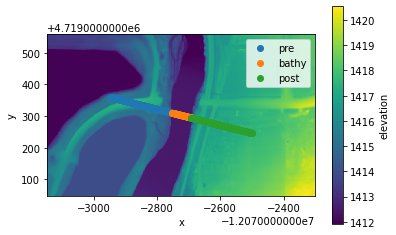

In [63]:
p1np = []
p2np = []
for index, v in enumerate(np.arange(1, 201, 1)):
    p1np.insert(0, {'lon': p1nx + v*np.cos(theta), 'lat': p1ny + v*np.sin(theta)})
    p2np.insert(0, {'lon': p2[0] + v*np.cos(theta), 'lat': p2[1] + v*np.sin(theta)})
df_pre = pd.DataFrame(p1np)   
gdf_data_pre = gpd.GeoDataFrame(df_pre, geometry=gpd.points_from_xy(df_pre.lon, df_pre.lat))
df_post = pd.DataFrame(p2np)
gdf_data_post = gpd.GeoDataFrame(df_post, geometry=gpd.points_from_xy(df_post.lon, df_post.lat))
fig, ax = plt.subplots()
dem.plot(ax=ax)
gdf_data_pre.plot(ax=ax, label='pre')
gdf_data.plot(ax=ax, label='bathy')
gdf_data_post.plot(ax=ax, label='post')

plt.legend()


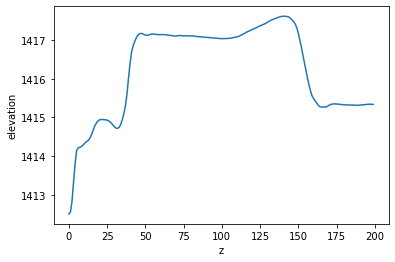

In [69]:
x = gdf_data_pre.geometry.x.values
y = gdf_data_pre.geometry.y.values
dsx = xr.DataArray(x, dims='z')
dsy = xr.DataArray(y, dims='z')
dsi_pre = dem.interp(x=('z',x), y=('z',y))
dsi_pre.plot()